# Test notebook, analyzing real data (US wildfires)

In this notebook I analyze a nice dataset I found on Keggle with data on wildfires in the USA.
Can be downloaded here: https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires/data

In [1]:
import sqlite3
import pandas as pd

# Here I import the essential data I need from the SQLite database
DB_PATH = "FPA_FOD_20170508.sqlite"   # (I put the sqlite in the same folder)


conn = sqlite3.connect(DB_PATH)

query = """
SELECT
    FIRE_SIZE,
    DISCOVERY_DATE,
    CONT_DATE,
    FIRE_YEAR,
    STATE,
    LATITUDE,
    LONGITUDE
FROM Fires
WHERE FIRE_SIZE IS NOT NULL
  AND FIRE_SIZE > 0
  AND DISCOVERY_DATE IS NOT NULL
"""

df = pd.read_sql_query(query, conn) 

conn.close()


In [2]:
df['DURATION_DAYS'] = (df['CONT_DATE'] - df['DISCOVERY_DATE'])

In [3]:
df = df.dropna(subset=["FIRE_SIZE", "DURATION_DAYS","CONT_DATE", "DISCOVERY_DATE"])
df = df[df['DURATION_DAYS'] >= 0]

In [4]:
fire_sizes = df['FIRE_SIZE'].to_numpy()

Text(0.5, 0, 'Fire Size (acres)')

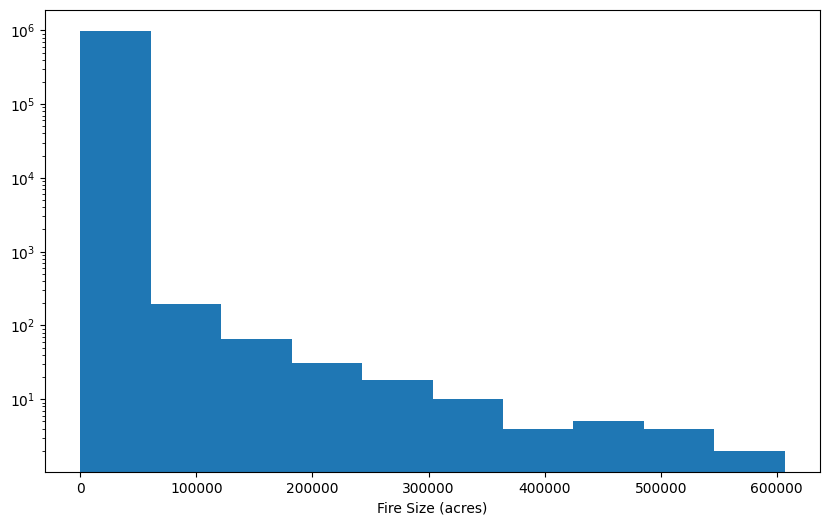

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Histogram of fire sizes
plt.figure(figsize=(10, 6))
plt.hist(fire_sizes)
plt.yscale('log')
plt.xlabel('Fire Size (acres)')


In [6]:
median_fs = np.median(fire_sizes)
max_fs = np.max(fire_sizes)
mean_fs = np.mean(fire_sizes)
std_fs = np.std(fire_sizes)

print(f"Median fire size: {median_fs}, Max fire size: {max_fs}, Mean fire size: {mean_fs}, Std dev: {std_fs}")

Median fire size: 0.5, Max fire size: 606945.0, Mean fire size: 119.2680979439457, Std dev: 3374.634404885927


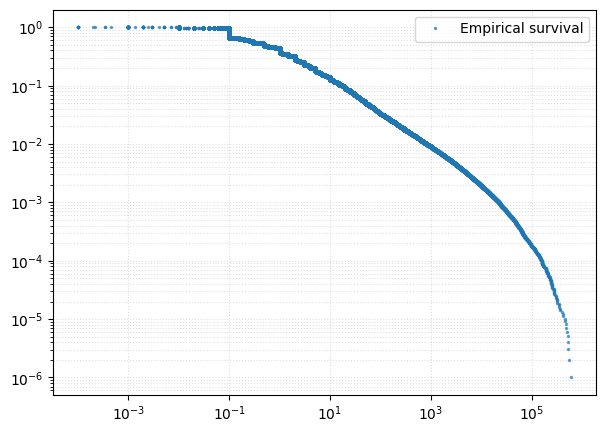

In [7]:
# plot of survival function and power-law fit on loglog plot
x = np.sort(fire_sizes) # sorting the data allows to easily compute empirical survival below!
n = len(x)

# empirical survival S(x) = P(X > x) evaluated at sorted x
surv = 1.0 - np.arange(0, n) / n  # survival at x[i] is 1 - i/n


# plot on log-log
plt.figure(figsize=(7,5))
plt.loglog(x, surv, marker='.', linestyle='none', markersize=3, alpha=0.6, label='Empirical survival')


plt.legend()
plt.grid(which='both', linestyle=':', alpha=0.4)
plt.show()

Above, the survival function appears to have a power law behavior between 10^0 and 10^5 circa. After, there seems to be a stronger suppression. Let's look at the mean excess plot then

In [8]:
import functions.analysis as fa

Text(0.5, 0, 'Threshold u')

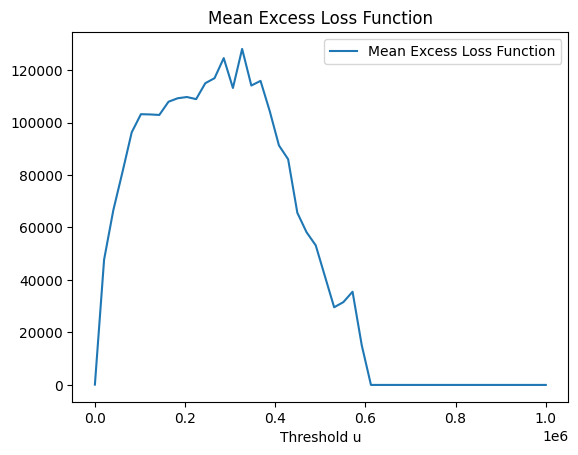

In [9]:
# plot of mean excess loss function
u_values = np.linspace(0, 1000000, 50)
mef_values = [fa.mean_excess_loss(fire_sizes, u) for u in u_values]
plt.plot(u_values, mef_values, label='Mean Excess Loss Function')
plt.title('Mean Excess Loss Function')
plt.legend()
plt.xlabel('Threshold u')

Text(0.5, 0, 'Threshold u')

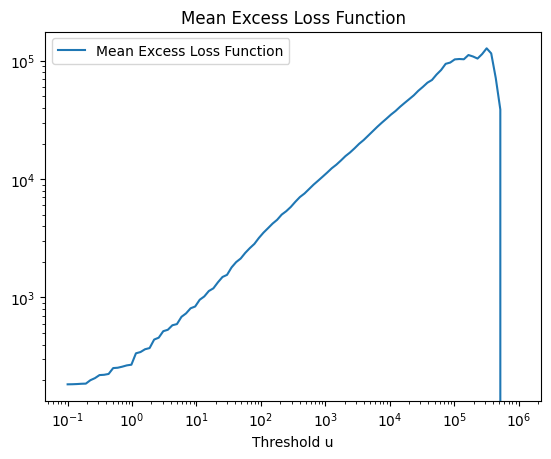

In [10]:
# plot of mean excess loss function
u_values = np.logspace(-1, 6, 100)
mef_values = [fa.mean_excess_loss(fire_sizes, u) for u in u_values]
plt.loglog(u_values, mef_values, label='Mean Excess Loss Function')
plt.title('Mean Excess Loss Function')
plt.legend()
plt.xlabel('Threshold u')

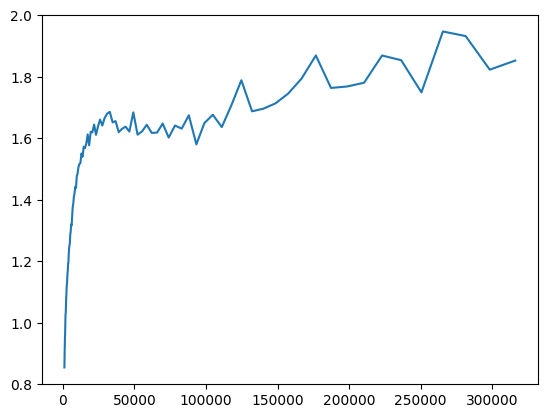

In [11]:
# plot of hill estimator as function of k
k_values = np.logspace(3, 5.5,100)
hill_values = np.array([fa.hill_estimator(fire_sizes, int(k)) for k in k_values])
plt.plot(k_values, hill_values)
#plt.xlabel('k (number of top order statistics)')
#plt.ylim(0.5, 1.5)

In [12]:
fa.pareto_tail_survival(fire_sizes,p_min=0.80,p_max=0.99)

np.float64(0.5745257851304635)

In [13]:
from scipy.optimize import curve_fit

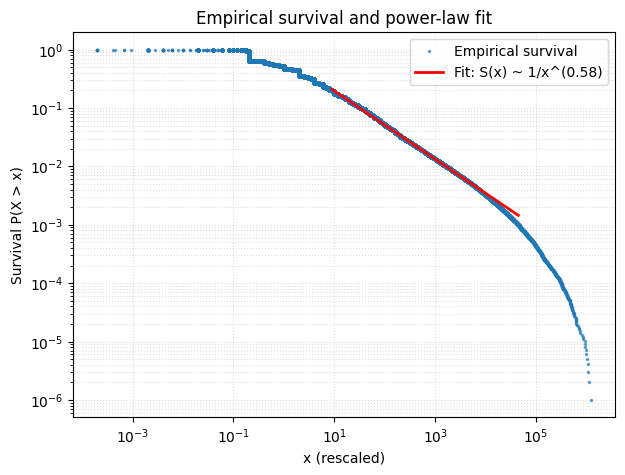

In [26]:
# plot of survival function and power-law fit on loglog plot
res_fs = fire_sizes/np.median(fire_sizes)

x = np.sort(np.asarray(res_fs)) # sorting the data allows to easily compute empirical survival below!
n = len(x)

# empirical survival S(x) = P(X > x) evaluated at sorted x
surv = 1.0 - np.arange(0, n) / n  # survival at x[i] is 1 - i/n

# choose tail threshold
u_min = np.percentile(res_fs, 80)
u_max = np.percentile(res_fs, 99.9)

mask = (x >= u_min) & (x <= u_max)

# fit log-log line: log S = intercept + slope * log x
logx = np.log(x[mask])
logsurv = np.log(surv[mask])
slope, intercept = np.polyfit(logx, logsurv, 1)
alpha_hat = -slope

# plot on log-log
plt.figure(figsize=(7,5))
plt.loglog(x, surv, marker='.', linestyle='none', markersize=3, alpha=0.6, label='Empirical survival')
# overlay fitted straight line (extrapolate across the tail region)
x_fit = np.linspace(x[mask].min(), x[mask].max(), 200)
plt.loglog(x_fit, np.exp(intercept) * x_fit**slope, 'r-', lw=2, label=f'Fit: S(x) ~ 1/x^({alpha_hat:.2f})')

plt.xlabel('x (rescaled)')
plt.ylabel('Survival P(X > x)')
plt.title(f'Empirical survival and power-law fit')
plt.legend()
plt.grid(which='both', linestyle=':', alpha=0.4)
plt.show()

Initial alpha (from Hill, k=9889): 0.6712
Selecting tail in range [0.20, 1213890.00] with 639502 points.


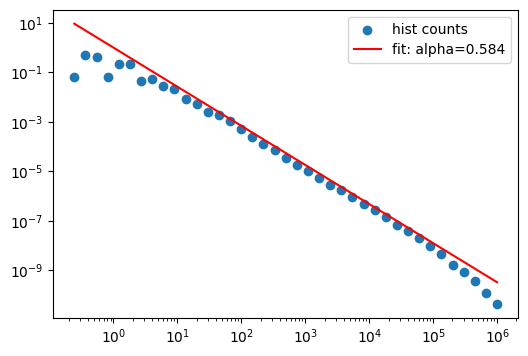

In [30]:


# choose k for hill estimator initial guess
n = len(res_fs)
k0 = int(0.01 * n)
gamma_hat = fa.hill_estimator(res_fs, k0)  # hill gives gamma = 1/alpha
alpha0 = 1.0 / gamma_hat # initial alpha estimate
print(f'Initial alpha (from Hill, k={k0}): {alpha0:.4f}')

# select tail threshold and compute log-spaced histogram
u_min = np.percentile(res_fs, 10)
u_max = np.percentile(res_fs, 100)
tail = res_fs[(res_fs > u_min) & (res_fs < u_max)]

print(f'Selecting tail in range [{u_min:.2f}, {u_max:.2f}] with {len(tail)} points.')

bins = np.logspace(np.log10(u_min), np.log10(u_max), 40)
counts, edges = np.histogram(tail, bins=bins, density=True) # density=True for PDF, otherwise the fit is off (because the bins are not uniform in width)
bin_centers = np.sqrt(edges[:-1] * edges[1:])

# use only bins with positive counts in the tail region
mask = counts > 0
x = bin_centers[mask]
y = counts[mask].astype(float)

def power_law(x, A, alpha):
    return A * x ** (-alpha-1)

alpha_fit = alpha_hat


# plot results
plt.figure(figsize=(6,4))
plt.scatter(x, y, label='hist counts')
xx = np.linspace(x.min(), x.max(), 200)
plt.plot(xx, power_law(xx, 1, alpha_fit),
         color='red', label=f'fit: alpha={alpha_fit:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


(For some reason the direct fitting of the histogram doesn't work well, overflow issue. In any case, if I use the value fitted before, the agreement is pretty spot on!)

Thus, I expect that, when defining severities as a function of (mostly) fire size, I will get heavy-tail distributed severities, hence same distribution for aggregate losses.
In any case, it is interesting to study the distribution of durations and their behavior with size. Possibly, we could model duration vs size and extract a residual for each fire, and use this residual for a model of the severity (a longer-than-usual fire of a given size should "cost" more).
Finally, the severity should also account on location, so maybe one could introduce a factor for each state related to population density?

One interesting observation is that, at this level, large wildfires are prototypical "black swans", apparently following the same underlying dynamics of smaller fires, just on a different scale (self similarity). There appears to be no "dragon kings" (i.e. extremal events that originate for different exceptional mechanisms, such as phase transitions). 

We can try to look at more localized datasets and check for the extremes there. Dragon kings easily come up in simplified models of wildfires when finite size effects matter, so maybe they could be seen in states with small, confined forests and relatively low frequency of firing events?